# Build a Recommendation System for Purchase Data

## Settings

Prepare the enviroments with libraries and utility functions

In [7]:
#Libraries

#Data
import sqlalchemy as sql

#Data Science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor, BaselineOnly
from surprise import KNNBasic,KNNWithMeans,KNNWithZScore,KNNBaseline
from surprise import SVD,SVDpp,NMF
from surprise import SlopeOne, CoClustering
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.accuracy import rmse, mae
from surprise import dump

#Model Tracking
import mlflow
from mlflow.tracking import MlflowClient
# TRACKING_URI = 'http://mlflow:5000'
# mlflow.set_tracking_uri(TRACKING_URI)

#Utils
import os
import configparser
from collections import defaultdict
import tempfile
import time
import json

In [8]:
# Enviroment Variables
outdata = '../data'
outmodels = '../models'
dbconnPath = './dbconn.properties'

# Set dbconnection variables
config = configparser.RawConfigParser()
config.read(dbconnPath)
params = config
db_host=params.get('CONN', 'host')
db_port=params.get('CONN', 'port')
db_user=params.get('CONN', 'user')
db_pwd=params.get('CONN', 'password')
db_name=params.get('CONN', 'database')

# Set connection string
connection_str = f'mysql+pymysql://{db_user}:{db_pwd}@{db_host}:{db_port}/{db_name}'

## Data Preparation

We have to:

1) Split each list of items in the products column into rows

2) Count the number of products bought by a user

In [9]:
# connect to database
engine = sql.create_engine(connection_str)
connection = engine.connect()

In [10]:
print(f'{db_name} contains {engine.table_names()[0]}, {engine.table_names()[1]} tables')
print(f'{db_name} contains {engine.table_names()[0]} table')

database contains CUSTOMERID, TRANSACTIONS tables
database contains CUSTOMERID table


In [11]:
# Convert tables in dataframes (Don't do that if you have a large dataset. Use just samples)
df_cus = pd.read_sql("select * from CUSTOMERID", connection)
df_trx = pd.read_sql("select * from TRANSACTIONS", connection)
connection.close()

In [12]:
print(df_cus.shape)
df_cus.head()

(1000, 2)


,id,customerId
0,1,1553
1,2,20400
2,3,19750
3,4,6334
4,5,27773


In [13]:
print(df_trx.shape)
df_trx.head()

(62483, 3)


,id,customerId,products
0,1,0,20
1,2,1,2|2|23|68|68|111|29|86|107|152
2,3,2,111|107|29|11|11|11|33|23
3,4,3,164|227
4,5,5,2|2


In [14]:
data_prep_1=pd.DataFrame(df_trx.products.str.split('|').tolist(), index=df_trx.customerId)\
.stack()\
.reset_index()\
.groupby(['customerId', 0])\
.agg({0: 'count'})\
.rename(columns={0: 'purchase_count'})\
.reset_index()\
.rename(columns={0: 'productId'})

In [15]:
print(data_prep_1.head())
print('*'*40)
print(data_prep_1.info())

  customerId productId  purchase_count
0          0         1               2
1          0        13               1
2          0       136               2
3          0       157               1
4          0        19               3
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133585 entries, 0 to 133584
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   customerId      133585 non-null  object
 1   productId       133585 non-null  object
 2   purchase_count  133585 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.1+ MB
None


In [16]:
#Let's normalize data in a way to have a rank
data_prep_2 = pd.pivot_table(data=data_prep_1, index='customerId', columns='productId', values='purchase_count', aggfunc='sum')
data_prep_3 = (data_prep_2 - data_prep_2.min())/(data_prep_2.max() - data_prep_2.min())
data_prep_4 = data_prep_3.reset_index().melt(id_vars=['customerId'], value_name='prod_ratings').dropna()
data_prep_4.index = np.arange(0, len(data_prep_4))
data_prep_4['prod_ratings'] = data_prep_4['prod_ratings'].apply(lambda x: int((round(x, 2))*10))

In [17]:
print(data_prep_4.sort_values(by=['customerId']).head())

       customerId productId  prod_ratings
1307            0         1             1
54157           0        20             0
49722           0       198             0
46478           0        19             1
116292          0        69             2


Then, we get **Triplet Representation** with each column representing user, item and the given rating respectively.
Notice the rating goes from 0–100 (with 100 being the most number of purchase for an item and 0 being 0 purchase count for that item).
It's a kind of preference for each user


## Data Exploration

Explore syntetic ratings by UserID and ProductID

### Rating Distributions

In [ ]:
df_plt1=data_prep_4['prod_ratings']
fig, ax = plt.subplots(figsize=(7, 3))
plt.hist(df_plt1)
ax.set_xlabel('Syntetic Product Ratings')
ax.set_ylabel('Frequency')
ax.set_title('Rating Distribution')
plt.show()

### Rating Distribution by ProductId

In [ ]:
df_plt_2=data_prep_4.groupby('productId')['prod_ratings'].count().reset_index()[0:50]
df_plt_2
fig, ax = plt.subplots(figsize=(7, 3))
plt.bar(df_plt_2.productId, df_plt_2.prod_ratings, )
ax.set_xlabel('Number of Ratings per product')
ax.set_ylabel('Count')
ax.set_title('Rating Distribution by ProductId')
plt.show()

In [ ]:
df_plt_2.sort_values(by='prod_ratings', ascending=False)[0:10]

In [ ]:
df_plt_2=data_prep_4.groupby('productId')['prod_ratings'].count()
df_plt_2
fig, ax = plt.subplots(figsize=(7, 3))
plt.hist(df_plt_2)
ax.set_xlabel('Number of Ratings')
ax.set_ylabel('Count')
ax.set_title('Rating Distribution by ProductId')
plt.show()

### Ratings Distribution By User

In [ ]:
df_plt_3=data_prep_4.groupby('customerId')['prod_ratings'].count().reset_index()[0:50]
fig, ax = plt.subplots(figsize=(7, 3))
plt.bar(df_plt_3.customerId, df_plt_3.prod_ratings)
ax.set_xlabel('Number of Ratings per Customer')
ax.set_ylabel('Count')
ax.set_title('Rating Distribution by customerId')
plt.show()

In [ ]:
df_plt_3.sort_values(by='prod_ratings', ascending=False)[0:10]

In [ ]:
df_plt_3=data_prep_4.groupby('customerId')['prod_ratings'].count()
fig, ax = plt.subplots(figsize=(7, 3))
plt.hist(df_plt_3)
ax.set_xlabel('Number of Ratings per Customer')
ax.set_ylabel('Frequency')
ax.set_title('Rating Distribution by customerId')
plt.show()

## Model Training and Evaluation

To do that, I use **Surprise** which is an easy-to-use Python scikit for recommender systems.

I follow the Getting Started (https://surprise.readthedocs.io/en/stable/getting_started.html#getting-started)

Reference: https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html

### Settings and Utility Functions (mlflow_tracker, get_Iu, get_Ui)

In [18]:
# A reader is required with the rating_scale param
mindata = data_prep_4.prod_ratings.min()
maxdata = data_prep_4.prod_ratings.max()
reader = Reader(rating_scale=(mindata,maxdata))

# The columns must correspond to user id, item id and ratings (in that order)
data_prep_5 = data_prep_4.rename(columns={'customerId': 'userID', 'productId':'itemID', 'prod_ratings':'rating'})
data_prep_5.to_csv(os.path.join(outdata, 'sample_toscore.csv'))
data = Dataset.load_from_df(data_prep_5[['userID', 'itemID', 'rating']], reader)

#Create the experiment
mlflow.set_experiment('Purchase Recommended System')

#Create Minio Bucket for Artefact Storage
%run -t 00_set_bucket.ipynb


def mlflow_tracker(reader_data, algo, params, rundesc='myrun'):
    """ 
    return the run id and experiment id of each model
    args: 
      reader_data: data parsed with Reader class 
      params: paramters of cross_validate function
      rundesc: A description to populate exoeriment note
      
    returns: 
      run_id and experiment_id
    """
        
    # Store Algo name
    algo_name = str(algo.__class__.__name__)

    with mlflow.start_run(run_name=algo_name) as run:

        # Store run_id and experiment_id
        run_id=run.info.run_uuid
        experiment_id=run.info.experiment_id
        
        #Create model instance
        redic=cross_validate(algo, reader_data, **params)
        #Create a dataframe of means
        recdf=pd.DataFrame.from_dict(redic).mean(axis=0)

        #Log params
        mlflow.log_params(params)
        mlflow.log_metric('test_time', recdf.iloc[3])
        mlflow.log_metric('test_rmse_mean', recdf.iloc[0])
        mlflow.log_metric('test_mae_mean', recdf.iloc[1])
        mlflow.log_metric('fit_time', recdf.iloc[2])

        # Set the notes for Runs

        MlflowClient().set_tag(run_id,
                               "mlflow.note.content",
                               rundesc)

    return (run_id, experiment_id)

BucketAlreadyOwnedByYou: BucketAlreadyOwnedByYou: message: Your previous request to create the named bucket succeeded and you already own it.

### Basic usage: Automatic cross-validation

#### Basic Algorithms

##### random_pred.NormalPredictor
Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.
##### baseline_only.BaselineOnly
Algorithm predicting the baseline estimate for given user and item.

#### KNN algorithms

##### knns.KNNBasic
A basic collaborative filtering algorithm
##### knns.KNNWithMeans
A basic collaborative filtering algorithm, taking into account the mean ratings of each user.
##### knns.KNNWithZScore
A basic collaborative filtering algorithm, taking into account taking into account the z-score normalization of each user.
##### knns.KNNBaseline
A basic collaborative filtering algorithm taking into account a baseline rating.

#### Matrix Factorization-based algorithms
##### matrix_factorization.SVD
The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize.When baselines are not used, this is equivalent to Probabilistic Matrix Factorization
##### matrix_factorization.SVDpp
The SVD++ algorithm, an extension of SVD taking into account implicit ratings.
##### matrix_factorization.NMF
A collaborative filtering algorithm based on Non-negative Matrix Factorization.

#### Other Algorithms
##### slope_one.SlopeOne
A simple yet accurate collaborative filtering algorithm.
##### co_clustering.CoClustering
A collaborative filtering algorithm based on co-clustering.



In [ ]:
params = {'measures': ['RMSE', 'MAE'], 'cv':3, 'verbose': False}
algos = [BaselineOnly(), NormalPredictor(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), KNNBaseline(), SVD(), SVDpp(), SlopeOne(), CoClustering()]

for algo in algos:
    mlflow_tracker(data, algo, params)
    time.sleep(1)

**Comment:  Based on the Mlflow tracking service, the best model is BaselineOnly algorithm**

### Tuning the Best Model

In [19]:
def preparer(data, test_size=0.25):
    """ 
    return train and test sets 
    args: 
      data: data parsed with Reader class 
    returns: 
      trainset and testset
    """
    trainset, testset = train_test_split(data, test_size=test_size)
    return trainset, testset

def trainer(trainset, bsl_options):
    """ 
    return trained model 
    args: 
      trainset: training data parsed with Reader class
      bsl_option: algorithm options 
    returns: 
      trained model
    """
    algo = BaselineOnly(bsl_options=bsl_options)
    model = algo.fit(trainset)
    return model

def predictor(model, testset):
    """ 
    return trained model and predictions
    args: 
      model: trained model
      testset: test data parsed with Reader class 
    returns: 
      trained model
    """
    predictions = model.test(testset)
    return model, predictions

def tuner(data, bsl_options_grid, param_model):
    """ 
    return model parameters, tuning history and best tuned model
    args: 
      data: data parsed with Reader class 
      bsl_options_grid:  algorithm options grid
      param_model: error measures and cross validation parameters 
    returns: 
      param_model, history_tune, tuned_model
    """
    
    gs = GridSearchCV(BaselineOnly, bsl_options_grid, **param_model)
    gs.fit(data)
    
    history_tune=pd.DataFrame.from_dict(gs.cv_results)
    
    best_bsl_options = gs.best_params['rmse']
    
    train, test = preparer(data)
    tuned_model = trainer(train, best_bsl_options)
    
    return param_model, history_tune, tuned_model

 # Define utils functions for prediction readability

def get_Iu(trainset, uid):
    """
    return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0

def get_Ui(trainset, iid):
    """
    return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

def mlflow_tune_tracker(data, algo_name, param_grid, param_model, rundesc='myruntuned'):
    """ 
    return the run id and experiment id of tuned model
    args: 
      algo_name: the name of tuned algorithm 
      param_grid:  algorithm options grid
      param_model: error measures and cross validation parameters 
    returns: 
      run_id, experiment_id
    """
    
    with mlflow.start_run(run_name=algo_name) as run:

        # Store run_id and experiment_id
        run_id=run.info.run_uuid
        experiment_id=run.info.experiment_id

        #Train the model
        trainset, testset = preparer(data)

        #Tune
        params, history_tune, tuned_model = tuner(data, param_grid, param_model)

        #History
        for index, row in history_tune.iterrows():
            with mlflow.start_run(experiment_id=experiment_id, run_name=algo_name + str(index), nested=True) as subruns:

                bsl_options = row['params']
                params_tune = {**params, **bsl_options}

                #Log params
                mlflow.log_params(params_tune)
                mlflow.log_metric('fit_time',round(row['mean_fit_time'], 3))
                mlflow.log_metric('test_time', round(row['mean_test_time'], 3))
                mlflow.log_metric('test_rmse_mean', round(row['mean_test_rmse'], 3))
                mlflow.log_metric('test_mae_mean', round(row['mean_test_mae'], 3))

                #Log Model (artefact)
                temp = tempfile.NamedTemporaryFile(prefix="model", suffix=".pkl")
                temp_name = temp.name
                try:
                    model, predictions = predictor(trainer(trainset, bsl_options), testset)
                    dump.dump(temp_name, predictions, model)
                    mlflow.log_artifact(temp_name, 'model')
                finally:
                    temp.close()

                 #Log best predictions
                df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
                df['Iu'] = [get_Iu(trainset, uid) for uid in df.uid]
                df['Ui'] = [get_Ui(trainset, iid) for iid in df.iid]
                df['err'] = abs(df.est - df.rui)
                best_predictions = df.sort_values(by='err')[:10]
                temp = tempfile.NamedTemporaryFile(prefix="best-predicitions", suffix=".csv")
                temp_name = temp.name
                try:
                    best_predictions.to_csv(temp_name, index=False)
                    mlflow.log_artifact(temp_name)
                finally:
                    temp.close()
                    
        MlflowClient().set_tag(run_id,
                   "mlflow.note.content",
                   rundesc)

    return run_id, experiment_id    

In [30]:
param_grid = {'bsl_options' : {'method': ['als', 'sgd'],
              'n_epochs': [5, 15],
              'reg_u': [10, 20],
              'reg_i': [5,15]               
                }
              }

param_model = {
          'measures': ['RMSE', 'MAE'], 
          'cv':3
            }

run_id, experiment_id = mlflow_tune_tracker(data, 'BaselineOnly', param_grid, param_model)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

## Model validation

Comment the best and the worst predictions

**This is the best parameter combination**

Then the best model is BaselineOnly with 
- method: 'als'
- n_epochs: 15
- reg_u: 10
- reg_i: 5

**Compare to all the experiments we ran so we validate the model as the best one based on RMSE metric**

### Train, test and comment predictions

In [21]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 15,
               'reg_u': 10,
               'reg_i': 5
               }

trainset, testset = train_test_split(data, test_size=0.25)
algo_best = BaselineOnly(bsl_options=bsl_options)
predictions = algo_best.fit(trainset).test(testset)

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = [get_Iu(trainset, uid) for uid in df.uid]
df['Ui'] = [get_Ui(trainset, iid) for iid in df.iid]
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

Using ALS
Estimating biases using als...


### Best predictions

In [22]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
13621,3698,25,0.0,0.0,{'was_impossible': False},5,775,0.0
26048,20748,219,0.0,0.0,{'was_impossible': False},8,275,0.0
6612,12114,17,0.0,0.0,{'was_impossible': False},5,830,0.0
14365,14149,14,0.0,0.0,{'was_impossible': False},5,924,0.0
4214,7848,2,0.0,0.0,{'was_impossible': False},9,2792,0.0
21424,7614,82,0.0,0.0,{'was_impossible': False},4,213,0.0
2864,18069,14,0.0,0.0,{'was_impossible': False},5,924,0.0
17296,10633,153,0.0,0.0,{'was_impossible': False},12,323,0.0
30232,13679,16,0.0,0.0,{'was_impossible': False},8,649,0.0
19269,21941,92,0.0,0.0,{'was_impossible': False},8,411,0.0


### Worst Predictions

**Comments**: Because Ui is anywhere between 275 to 2792, it's good because we have a lot of people who buy the product (a kind of preference)

In [23]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
15589,3,196,10.0,0.353682,{'was_impossible': False},3,275,9.646318
4508,3260,23,10.0,0.298553,{'was_impossible': False},16,603,9.701447
2966,22548,122,10.0,0.265711,{'was_impossible': False},4,347,9.734289
572,9360,209,10.0,0.247787,{'was_impossible': False},13,269,9.752213
24834,229,275,10.0,0.238495,{'was_impossible': False},11,215,9.761505
715,17425,224,10.0,0.218142,{'was_impossible': False},1,267,9.781858
31559,6462,116,10.0,0.182018,{'was_impossible': False},4,364,9.817982
328,3062,47,10.0,0.053785,{'was_impossible': False},30,494,9.946215
28152,6688,25,10.0,0.000000,{'was_impossible': False},5,775,10.000000
20464,1404,148,10.0,0.000000,{'was_impossible': False},14,227,10.000000


**Comments**: Really bad. Because consider the item 148, the user buy it 0 times but the algorithm says he buy always, Also if we look at distribution only few people buy it frequently

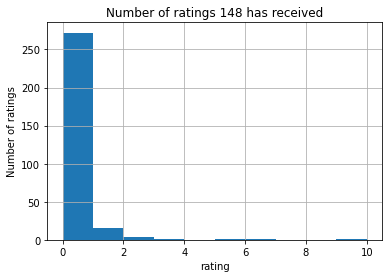

In [27]:
data_prep_4.loc[data_prep_4['productId'] == '148']['prod_ratings'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings 148 has received')
plt.show();

## Model Registration

Register the Model in the Mlflow Model Registry and set its status as STAGING

In [31]:
model_name = 'Champion'
artifact_path = "model"
model_uri = "runs:/{run_id}/{artifact_path}".format(run_id=run_id, artifact_path=artifact_path)

model_details = mlflow.register_model(model_uri=model_uri, name=model_name)

Registered model 'Champion' already exists. Creating a new version of this model...
Created version '2' of model 'Champion'.


In [34]:
client = MlflowClient()
client.update_registered_model(
  name=model_details.name,
  description="This model provides recommendation for specific users and items based on purchase data. The data consists of user transactions"
)

client.update_model_version(
  name=model_details.name,
  version=model_details.version,
  description="This model was built with Surprise library. It is a ALS based BaselineOnly algorithm"
)

client.transition_model_version_stage(
  name=model_details.name,
  version=model_details.version,
  stage='Staging',
)
model_version_details = client.get_model_version(
  name=model_details.name,
  version=model_details.version,
)
print("The current model stage is: '{stage}'".format(stage=model_version_details.current_stage))

The current model stage is: 'Staging'
